# Generative and Discriminative Classifiers

The aim of classification tasks is to learn a $\theta$-parameterized function $f_\theta(x)$ that returns an output y from a finite set for a given input x. In the context of probabilistic modelling, we are interested in decision functions of the form:
$$f_\theta(x)=\arg\max_y p(y|x;\theta).$$

This notebook studies two different ways - generative and discriminative - to estimate the parameters $\theta$ from data. Naive Bayes is a representative for generative models, whereas Logistic Regression estimates the parameters in a discriminative way. Tom Mitchell's book [1] gives a very good analysis of the differences between Logistic Regression and (Gaussian) Naive Bayes. The main statements are:
- Logistic Regression (discriminative) estimates p(y|x), Naive Bayes (generative) estimates p(x|y) and p(y).
- Logistic Regression and Gaussian Naive Bayes converge to the same solution when the modeling assumptions do hold.
- Logistic Regression converges slower (in order of n) than Gaussian Naive Bayes (in order of log(n)).
- If the modelling assumptions do not hold (especially the independence assumption of the features), Logistic Regression will adjust its parameters to maximize the fit to the data and will not converge to the solution of Gaussian Naive Bayes.

In summary, Logistic Regression outperforms Gaussian Naive Bayes when many training examples are available, but Gaussian Naive Bayes outperforms Logistic Regression when training data is scarce.

Note, that this is *not* a qualitive comparison between generative and discriminative classifiers.

[1] https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf

In [1]:
# plotting
import pylab as plt
from scipy.stats import multivariate_normal, binom
%matplotlib inline

# math
import numpy as np
import pandas as pd

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Model Assumption and Data Generation

The parameters of the function $\theta$ can be inferred using a set of in- and outputs. 

The model assumption of the data generating process is as follows. In order to generate a set of examples, first, the nature draws a label for each of the examples independent from each other and all from the same distribution (*iid* assumption). Secondly, given the class for each example, the corresponding input vector is drawn from a class-wise marginal distribution p(x|y) - again iid. p(x|y) is typically high-dimensional and can be either discrete (mulitnomial distribution) or continuous. 

In [2]:
def generate_data(n_samples, p_xy, p_y):
    """
    Generate data from p(x,y)=p(y)p(x|y):
    - draw a binary output label from p(y)
    - given the class, draw input vector from p(x|y)
    """
    y = p_y.rvs(n_samples)
    k = p_xy[y[0]].dim
    X = np.nan * np.zeros((n_samples, k))
    for c in set(y):
        n_samples_c = sum(y==c)
        X[y==c, :] = p_xy[c].rvs(n_samples_c)
    return X, y

For the sake of simplicity, we restrict ourselves to binary classification problems, where y is drawn from a Bernoulli distribution (y is either 0 or 1). The inputs are drawn from a 2-dimenional normal distribution with different means and (potentially different) covariance matrices for each class. 

Note that, if the covariance matrices are equal for all classes, the optimal classifier is a linear function. However, the model assumption is that the Gaussians might have different covariance matrices. Thus, the estimated model is typically non-linear due to the estimation variance.

In [3]:
p_y = binom(1, 0.5)
p_xy = {
    0: multivariate_normal([1, 0], [[2.0, 0.3], [0.3, 0.5]]),
    1: multivariate_normal([-1, 1], [[2.0, 0.3], [0.3, 0.5]])
}

X, y = generate_data(100, p_xy, p_y)
X_te, y_te = generate_data(100000, p_xy, p_y)

The Bayes-optimal decision is to predict the class with highest probability. Given the (typically unknown) real distribution, the optimal decision is to predict y=1 if $p(x,y=1)>p(x,y=0)$ and y=0 otherwise. Equivalently,
$$log\left(\frac{p(y=1)p(x|y=1)}{p(y=0)p(x|y=0)}\right)>0$$

In [4]:
def generative_f(p_y, p_xy):
    return lambda x: np.log(p_y.mean()*p_xy[1].pdf(x)/((1-p_y.mean())*p_xy[0].pdf(x)))

f_opt = generative_f(p_y, p_xy)

In the following, we visualize the data and its underlying distributions.

test accurary: 0.88336


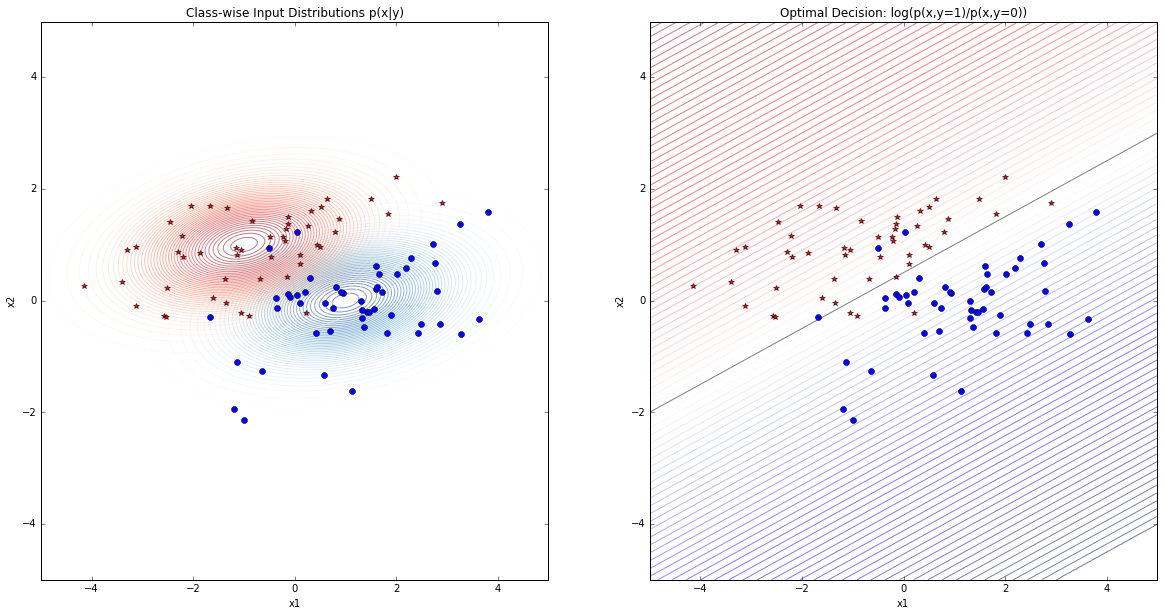

In [5]:
x1, x2 = np.mgrid[-5:5:.01, -5:5:.01]
x = np.empty(x1.shape + (2,))
x[:, :, 0] = x1; x[:, :, 1] = x2

def plot_decision_contours(scores, ax, title):
    m = 20
    scores = np.clip(scores, -m, m)
    levels = np.concatenate([np.arange(-m, 0, m/50.0), np.arange(0, m, m/50.0)])
    CS = ax.contour(x1, x2, scores, levels=levels, cmap='seismic', alpha=0.5)
    # paint decision boundary black
    plt.setp(CS.collections[np.where(levels==0)[0][0]], color='black')
    # plot data
    ax.plot(X[y==0,0], X[y==0,1],'bo')
    ax.plot(X[y==1,0], X[y==1,1],'r*')
    # set description
    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

# create subplots
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# plot class-wise distributions
ax1.contour(x1, x2, p_xy[0].pdf(x), 50, cmap='Blues', alpha=0.5)
ax1.contour(x1, x2, p_xy[1].pdf(x), 50, cmap='Reds', alpha=0.5)
# plot data
ax1.plot(X[y==0,0], X[y==0,1],'bo')
ax1.plot(X[y==1,0], X[y==1,1],'r*')
# set description
ax1.set_title('Class-wise Input Distributions p(x|y)')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

# plot optimal decision boundary
plot_decision_contours(f_opt(x), ax2, 'Optimal Decision: log(p(x,y=1)/p(x,y=0))')

print "test accurary:", (1*(f_opt(X_te)>0) == y_te).mean()

# Estimate Parameters

The parameters of the function $\theta$ can be inferred using a set of in- and outputs. A typical approach is to minimize the Kullback-Leibler divergence between the true and the estimated model, which leads to a maximum likelihood estimate (ML). Alternatively, we could consider a maximum-a-posteriori estimate or a fully Bayesian approach, which are out of scope.

There are two different approaches. The generative approach, models the input distribution, whereas the discriminative approach models the output distribution directly.

## Generative Approach

The distribution of the outputs y conditioned to the input x can be reformulated by applying Bayes rule:
$$p(y=1|x;\theta)=\frac{p(x|y=1;\theta)p(y=1;\theta)}{p(x|y=0;\theta)p(y=0;\theta)+p(x|y=1;\theta)p(y=1;\theta)}$$

Let first consider the class prior $p(y|\theta)$ for which we assume a Bernoulli distribution $Ber[\pi](y)$ with unknown head probablity $\pi$. Under the assumption, that all observations $y_1,\dots,y_n$ are drawn independently and all from the same distribution $p(y;\pi)$ (*iid* assumption), the ML estimate can be obtained in closed-form:
\begin{align}
\pi_{ml}&=\arg\max_\pi p(y_1,\dots,y_n;\pi)\\
&=\arg\max_\pi\prod_{i=1}^n p(y=y_i;\pi)&&\text{iid assumption}\\
&=\arg\max_\pi \prod_{i=1}^n\pi^{[y=1]}(1-\pi)^{1-[y=1]}&&\text{definition of $Ber[\pi]$}\\
&=\arg\max_\pi \sum_{i=1}^n[y=1]\log(\pi)+\sum_{i=1}^n\log(1-\pi)-\sum_{i=1}^n[y=1]\log(1-\pi)&&\text{$\log$ does not change argmax}\\
&=\arg\max_\pi \#\{y=1\}\log\left(\frac{\pi}{1-\pi}\right)+n\log(1-\pi)&&\#\{y=1\}:=\sum_{i=1}^n[y=1]\\
\end{align}
Taking the derivative and setting it to zero yields the fraction of instances with y=1:
$$
\pi_{ml}=\frac{\#\{y=1\}}{n}
$$

In [6]:
def estimate_binom(x):
    return binom(1, x.mean(axis=0))

# estimate parameters of class probabilty p(y)
p_y_gen = estimate_binom(y)

The class-wise input distribution $p(x|y)$ is typically high-dimensional. If we assume that $x=(x_1,\dots,x_k)$ is a vector of length $k$, where each component $x_i$ is binary, we need to estimate $2^k$ parameters. Naive Bayes assumes that all components are independent from each other. This reduces the number of parameters to $k$ for each class y.

In analogy, we can show that the ML estimate of a (multivariate) Gaussian distribution is given by its sample estimates.

In [7]:
def estimate_gaussian(x):
    return multivariate_normal(x.mean(axis=0), np.cov(x.T))

# estimate parameters of class-wise input probabilties p(x|y)
p_xy_gen = {c: estimate_gaussian(X[y==c, :]) for c in [0, 1]}

Now, we can compute the generative decision function.

test accurary: 0.88048


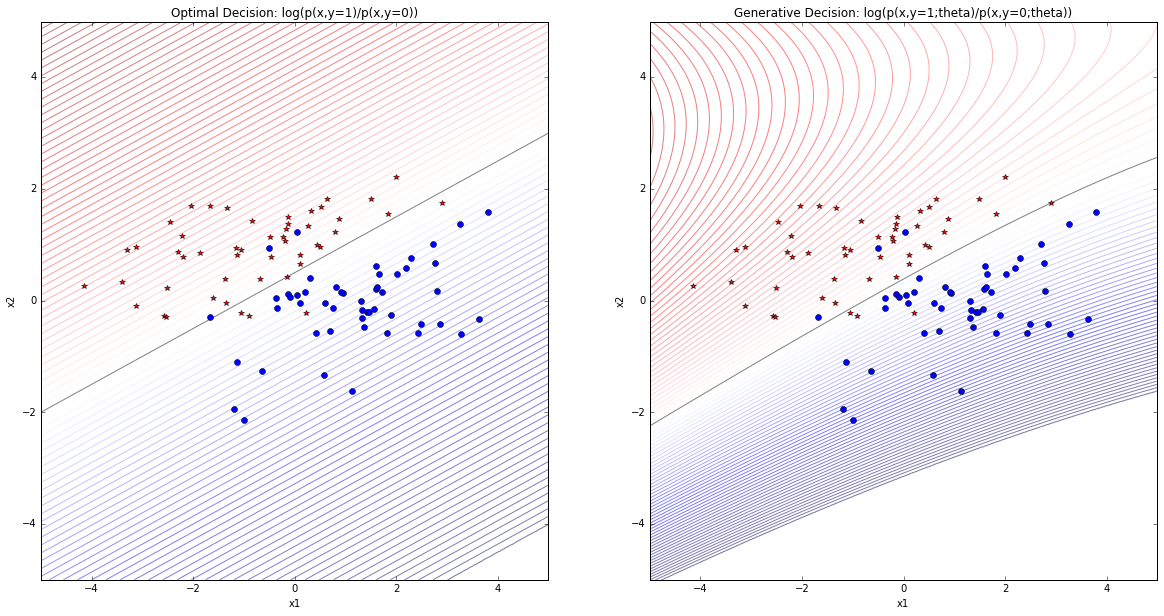

In [8]:
# get generative decision function
f_gen = generative_f(p_y_gen, p_xy_gen)

# create subplots
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# plot optimal decision boundary
plot_decision_contours(f_opt(x), ax1, 'Optimal Decision: log(p(x,y=1)/p(x,y=0))')
plot_decision_contours(f_gen(x), ax2, 'Generative Decision: log(p(x,y=1;theta)/p(x,y=0;theta))')

print "test accurary:", (1*(f_gen(X_te)>0) == y_te).mean()

## Discriminative Approach

Let's review, the Naive Bayes assumption for a $k$-dimensional Bernoulli input vector. Because we assume that the components are independent, the distribution of an input vector of class y, can be expressed as:

\begin{align}
  p(x|y;\theta)&=\prod_{i=1}^k p(x_i|y;\theta) && \text{iid assumption}\\
  &=\exp\left(\sum_{i=1}^k \log p(x|y;\theta)\right) && x=\exp(\log(x))\\
  &=\exp\left(\sum_{i=1}^k [x_i=1]\log \frac{\pi_{iy}}{1-\pi_{iy}}+\sum_{i=1}^k \log(1-\pi_{iy})\right) && \text{definition of $Ber[\pi]$}\\
  &=\exp\left(\phi(x)^T\theta+g(\theta)+h(x)\right),
\end{align}
where we have defined 
- the components of the parameter vector $\theta$ by $\theta_i=\log \frac{\pi_{iy}}{1-\pi_{iy}}$,
- the feature mapping $\phi(x)=x$,
- the base measure $h(x)=0$, and
- the log-partition function $g(\theta) = \sum_{i=1}^k \log(1-\pi_{iy})$. 
The form is known as the canonical form of the exponential family. The exponential family captures a lot commonly-used distribution classes (see [2] for an overview) and allows us to come up with a general classification function for a broad family of distributions. In our example, $p(x|y;\theta)=\mathcal{N}[\mu_y,\Sigma_y](x)$ is Gaussian. In this case,
- the parameter vector is $\theta=\left(\Sigma^{-1}\mu, -\frac{1}{2}vec(\Sigma^{-1})\right)^T$,
- the feature mapping is $\phi(x)=\left(x, x\otimes x\right)^T$, and
- the log-partition function $g(\theta)=\frac 1 2\mu^T\Sigma^{-1}\mu+\frac 1 2 \ln |\Sigma|$.

In contrast to the generative approach, the discriminative approach aims to estimate the predictive distribution. Let us assume that $p(x|y;\theta)$ belongs to an exponential family.
\begin{align}
  p(y=1|x;\theta)&=\frac{p(x|y=1;\theta)p(y=1;\theta)}{p(x|y=0;\theta)p(y=0;\theta)+p(x|y=1;\theta)p(y=1;\theta)}\\
  &=\frac{\exp\left(\phi(x)^T\theta_1+g(\theta_1)+h(x)\right)\pi_1}{\exp\left(\phi(x)^T\theta_0+g(\theta_0)+h(x)\right)\pi_0+\exp\left(\phi(x)^T\theta_1+g(\theta_1)+h(x)\right)\pi_1}&&\text{definition of exponential family}\\
  &=\frac{\exp\left(\phi(x)^T\theta_1+g'(\theta_1)+h(x)\right)}{\exp\left(\phi(x)^T\theta_0+g'(\theta_0)+h(x)\right)+\exp\left(\phi(x)^T\theta_1+g'(\theta_1)+h(x)\right)}&&g'(\theta):=g(\theta)+\log \pi\\
  &=\frac{1}{1+\exp\left(\phi(x)^T\theta_0+g'(\theta_0)-\phi(x)^T\theta_1-g'(\theta_1)\right)}&&\frac{a}{a+b}=\frac{1}{1+\frac{b}{a}}\text{ and } \frac{\exp(a)}{\exp(b)}=\exp(a-b)\\
  &=\frac{1}{1+\exp\left(-y\phi(x)^T\theta+b\right)}&&\theta:=\theta_0-\theta_1, b:=g'(\theta_0)-g'(\theta_1)
\end{align}
Note that we have redefined $y_{old}\in \{0,1\}$ by $y_{new}=2y_{old}-1\in\{\pm1\}$ for notational convenience. Furthermore, $b$ can be  subsumed by $\theta$ (and thus $\phi(x)$ augmented by 1).

The Gaussian assumption is reflected by just using a polynomial feature mapping $\phi(x)=\left(x, x\otimes x\right)^T$. In this case, the intercept $b$ captures the class differences regarding the mean $\mu$, the volume $|\Sigma|$ of the distribution, and the prior $\pi$.

The last equation shows that the predictive distribution can be seen as sigmoid function $\frac{1}{1+exp(-x)}$ applied to a generalized linear decision function. The maximum likelihood estimate under that model is then given by:
\begin{align}
 \theta_{ML} &=\arg\max_\theta \prod_{i=1}^n p(y_i|x_i;\theta)\\
 &=\arg\max_\theta \prod_{i=1}^n \frac{1}{1+\exp\left(-y_i\phi(x_i)^T\theta\right)}&&\text{plug in exponential family}\\
 &=\arg\max_\theta \sum_{i=1}^n \log\left(1+\exp\left(-y_i\phi(x_i)^T\theta\right)\right)&&\text{$\log$ does not change argmax}\\
\end{align}
This optimization problem does not have a closed-form solution. We will solve this in the following with the sklearn framework [3]. The logistic regression implements typically a maximum-a-posteriori estimate; however, the prior / regularization is out of scope of this notebook.

[2] https://en.wikipedia.org/wiki/Exponential_family

[3] http://scikit-learn.org/stable/

test accurary: 0.8749


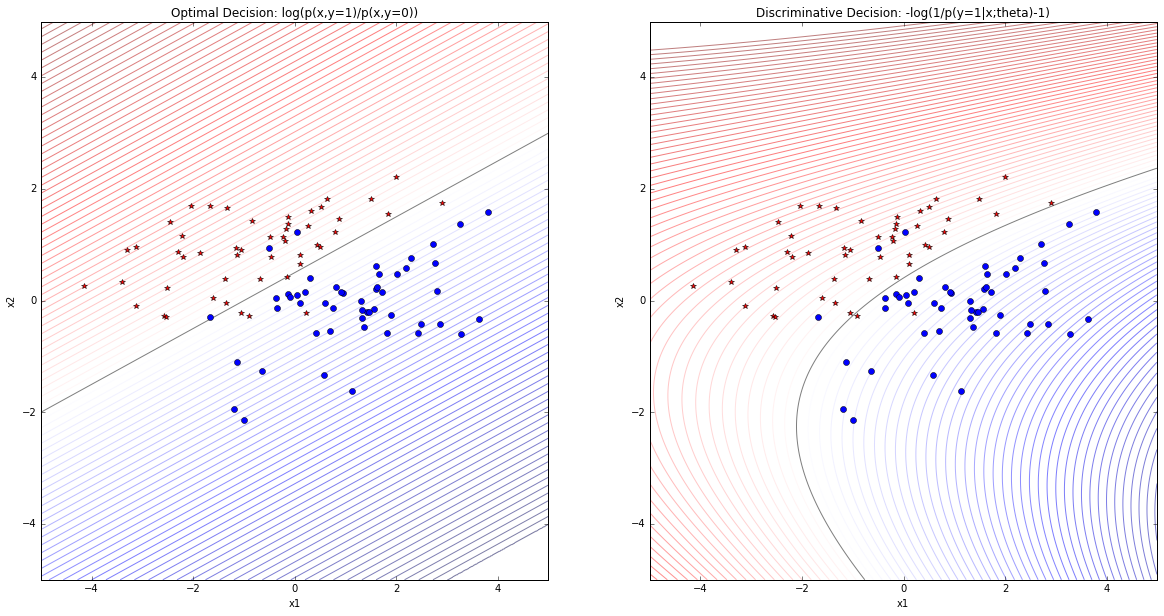

In [9]:
# estimate parameters
model = Pipeline([
    ('preprocessing', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('classifier', LogisticRegression())
]).fit(X,y)

# get generative decision function
f_disc = lambda x: -np.log(1/model.predict_proba(x)[:,1]-1)

# create subplots
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# plot optimal decision boundary
plot_decision_contours(f_opt(x), ax1, 'Optimal Decision: log(p(x,y=1)/p(x,y=0))')
plot_decision_contours(np.array([f_disc(x_row) for x_row in x]), ax2, 'Discriminative Decision: -log(1/p(y=1|x;theta)-1)')

print "test accurary:", (1*(f_disc(X_te)>0) == y_te).mean()